### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,log_loss
from tabulate import tabulate

### Declaring the Variables

In [3]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["1-1","1-2","1-4","PURE"]

In [128]:
image_dir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/BLACK_WHITE'

In [5]:
logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/Logs'

In [6]:
model_dir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/Model/'

In [7]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
image_data_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2240 files belonging to 4 classes.


In [129]:
train_val_set=image_data_set.take(100)
test_set=image_data_set.skip(100).take(40)
print(f'Using {len(train_val_set)} sets for Training and Validation')
print(f'Using {len(test_set)} sets for Testing')

Using 100 sets for Training and Validation
Using 40 sets for Testing


In [11]:
normalized_train_val_set=train_val_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [ ]:
def Build_Model():
  model=Sequential()
  
  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))  ##<------------------------sigmoid is used for binary classification, softmax need to be used here, try with softmax

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Peforming the 10 Fold Cross Validation

In [ ]:
i=0
j=10
k=90

for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_train_val_set.take(i)
  training_set2=normalized_train_val_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_train_val_set.skip(i).take(j)
  i=i+10
  j=10
  k=k-10
  
  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()


Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/20
90/90 [==============================] - 534s 5s/step - loss: 0.6384 - accuracy: 0.7069
Epoch 2/20
90/90 [==============================] - 6s 55ms/step - loss: 0.4175 - accuracy: 0.8271
Epoch 3/20
90/90 [==============================] - 7s 65ms/step - loss: 0.3893 - accuracy: 0.8375
Epoch 4/20
90/90 [==============================] - 6s 55ms/step - loss: 0.3912 - accuracy: 0.8465
Epoch 5/20
90/90 [==============================] - 7s 70ms/step - loss: 0.3657 - accuracy: 0.8375
Epoch 6/20
90/90 [==============================] - 6s 55ms/step - loss: 0.3289 - accuracy: 0.8743
Epoch 7/20
90/90 [==============================] - 7s 69ms/step - loss: 0.3135 - accuracy: 0.8604
Epoch 8/20
90/90 [==============================] - 6s 55ms/step - loss: 0.2876 - accuracy: 0.8819
Epoch 9/20
90/90 [==============================] - 7s 68ms/step - loss: 0.3333 - accuracy: 0.8757
Epoch 10/

In [ ]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |             22.8809  |                   91.25  |
+---------------+----------------------+--------------------------+
|             2 |             19.5626  |                   93.75  |
+---------------+----------------------+--------------------------+
|             3 |             38.3135  |                   92.5   |
+---------------+----------------------+--------------------------+
|             4 |              8.09805 |                   98.125 |
+---------------+----------------------+--------------------------+
|             5 |             58.498   |                   80     |
+---------------+----------------------+--------------------------+
|             6 |              7.77648 |                   97.5   |
+---------------+----------------------+--------

### Selecting the model with highest accuracy for training

In [ ]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(f'The maximum validation accuracy is: {max_acc}')
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(f'The folds having {max_acc} validation accuracy are:')
for i in range(len(max_acc_index)):
  print(max_acc_index[i]+1)

result=-1
if(len(max_acc_index)>1):
    min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
    j=0
    result=max_acc_index[0]
    while(j<len(max_acc_index)):
      index=max_acc_index[j]
      if(SCORES_PER_FOLD[index][1]<min_loss):
        min_loss=SCORES_PER_FOLD[index][1]
        result=index
      j+=1
else:
  result=max_acc_index[0]
print(f'Selecting the model of fold no {result+1} for fine parameter tuning')
model=load_model(model_dir+'model_'+str(result+1)+'.h5')

The maximum validation accuracy is: 99.37499761581421
The folds having 99.37499761581421 validation accuracy are:
8
Selecting the model of fold no 8 for fine parameter tuning


### Training the model for fine parameter tuning

In [ ]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

Cur_Model_Run = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tensorboard_callback]
  )

Epoch 1/30
80/80 [==============================] - 12s 130ms/step - loss: 0.0384 - accuracy: 0.9867 - val_loss: 0.0361 - val_accuracy: 0.9875
Epoch 2/30
80/80 [==============================] - 10s 120ms/step - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.0684 - val_accuracy: 0.9656
Epoch 3/30
80/80 [==============================] - 10s 116ms/step - loss: 0.0208 - accuracy: 0.9914 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 4/30
80/80 [==============================] - 10s 127ms/step - loss: 0.1547 - accuracy: 0.9531 - val_loss: 0.1348 - val_accuracy: 0.9531
Epoch 5/30
80/80 [==============================] - 15s 184ms/step - loss: 0.1528 - accuracy: 0.9531 - val_loss: 0.0654 - val_accuracy: 0.9719
Epoch 6/30
80/80 [==============================] - 10s 126ms/step - loss: 0.0791 - accuracy: 0.9766 - val_loss: 0.0487 - val_accuracy: 0.9937
Epoch 7/30
80/80 [==============================] - 10s 121ms/step - loss: 0.0240 - accuracy: 0.9914 - val_loss: 0.0113 - val_accuracy: 0.9937

### Saving the fine tuned model

In [ ]:
model.save('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/model_fine_tuned.h5')

In [12]:
model=load_model('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/model_fine_tuned.h5')

### Plotting the performance of the model after fine parameter tuning

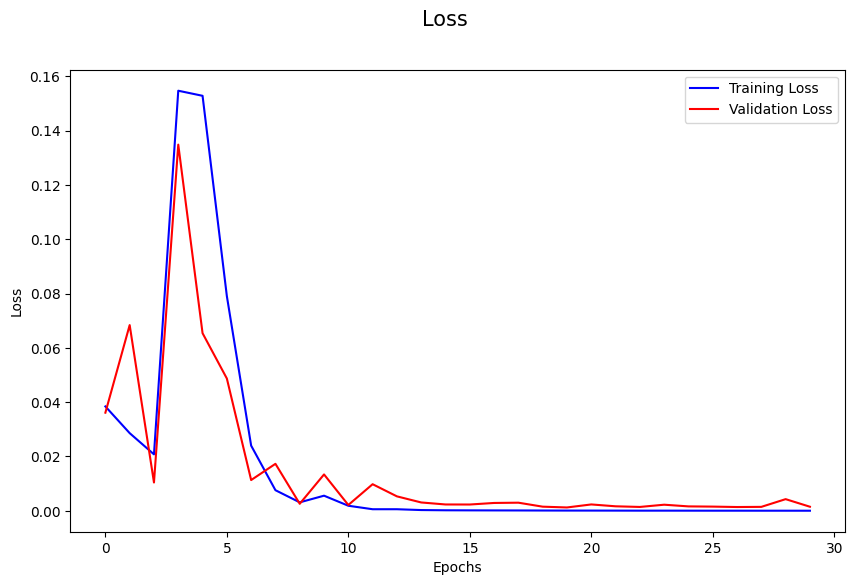

In [ ]:
# Plotting the loss


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/Loss.eps', format='eps', dpi=600)

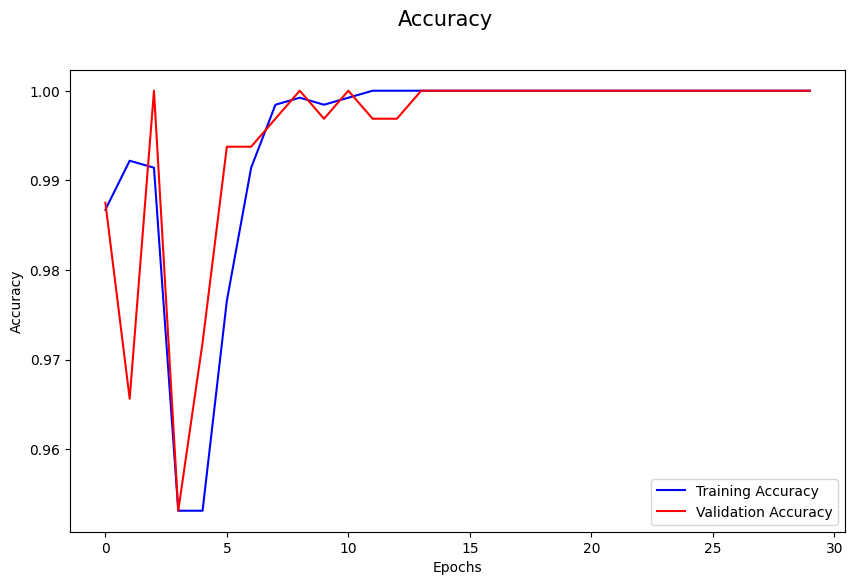

In [ ]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/Accuracy.eps', format='eps', dpi=600)

###Calcualting Precision, Recall, Accuracy and F Score of the Model

In [13]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [36]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):              
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 25ms/step


In [38]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [39]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [40]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [124]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)

In [59]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [60]:
Binarized_True_label

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [100]:
Predicted_probabilities=np.array(Predicted_probabilities)

In [101]:
print(Predicted_probabilities.shape)
print(Predicted_probabilities[0])

(640, 4)
[3.6448970e-01 1.0000000e+00 1.4718442e-04 1.4561195e-10]


In [102]:
fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [108]:
roc_auc_details=[]
column_headers=['CLASS','ROC-AUC']
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |  0.996411 |
+---------+-----------+
| 1-2     |  0.963278 |
+---------+-----------+
| 1-4     |  0.999497 |
+---------+-----------+
| PURE    |  1        |
+---------+-----------+


In [105]:
avg_roc_auc=sum(roc_auc)/4

In [106]:
print(avg_roc_auc)

0.9897963091553927


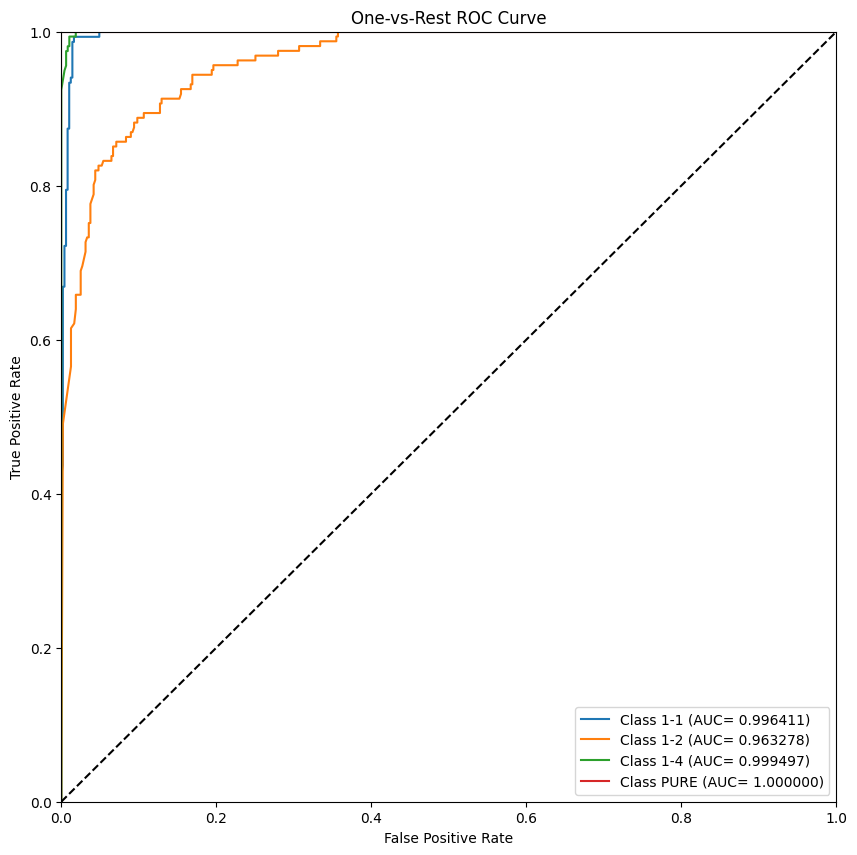

In [110]:
fig=plt.figure(figsize=(10,10));

color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

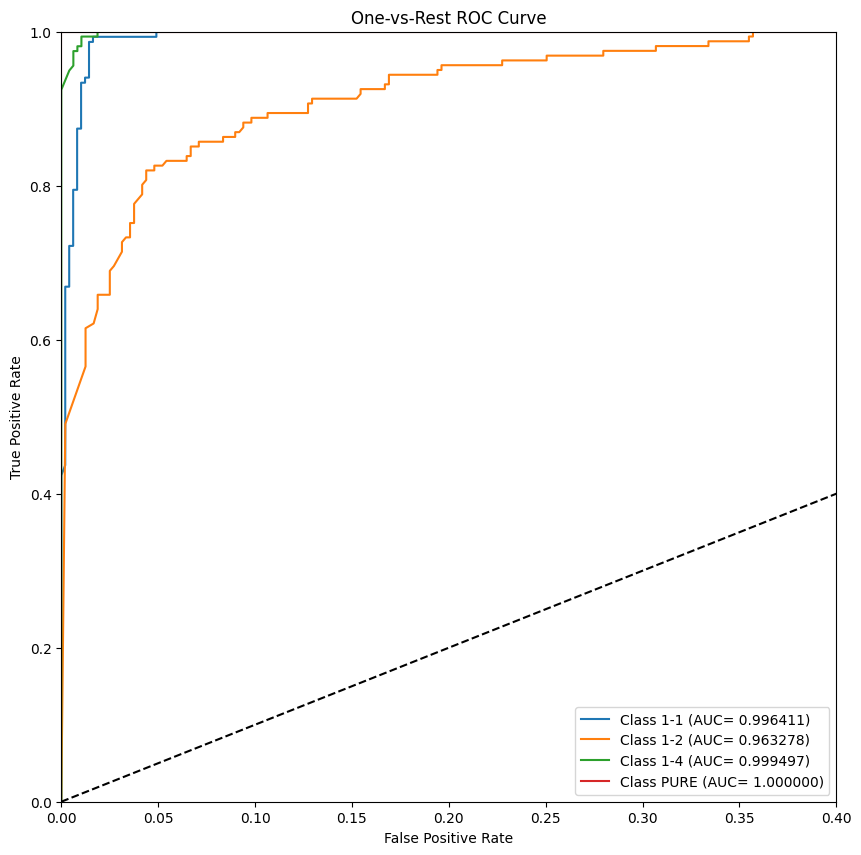

In [116]:
fig=plt.figure(figsize=(10,10));

color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.40])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# fpr = [0] * 4
# tpr = [0] * 4
# roc_auc= [0] * 4
# avg_roc_auc=0
# for i in range(4):
#     fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

In [146]:
type(True_label)

numpy.ndarray

In [154]:
def categorical_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid division by zero
    N = y_true.shape[0]
    
    # Clip predicted probabilities to avoid log(0) cases
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Calculate cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / N
    
    return loss

In [157]:
Binarized_True_label.shape[0]

640

In [155]:
loss = categorical_cross_entropy_loss(Binarized_True_label, Predicted_probabilities)
print("Cross-entropy loss:", loss)

Cross-entropy loss: 0.0007023984594489718


In [93]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}')

Precision: 0.9979231357574463, Recall: 0.9876670241355896, Accuracy: 0.9859374761581421, F Score: 0.9927685623461183


In [94]:
print(f'Cohen Kappa Score: {kappa}')

Cohen Kappa Score: 0.9812430394091557


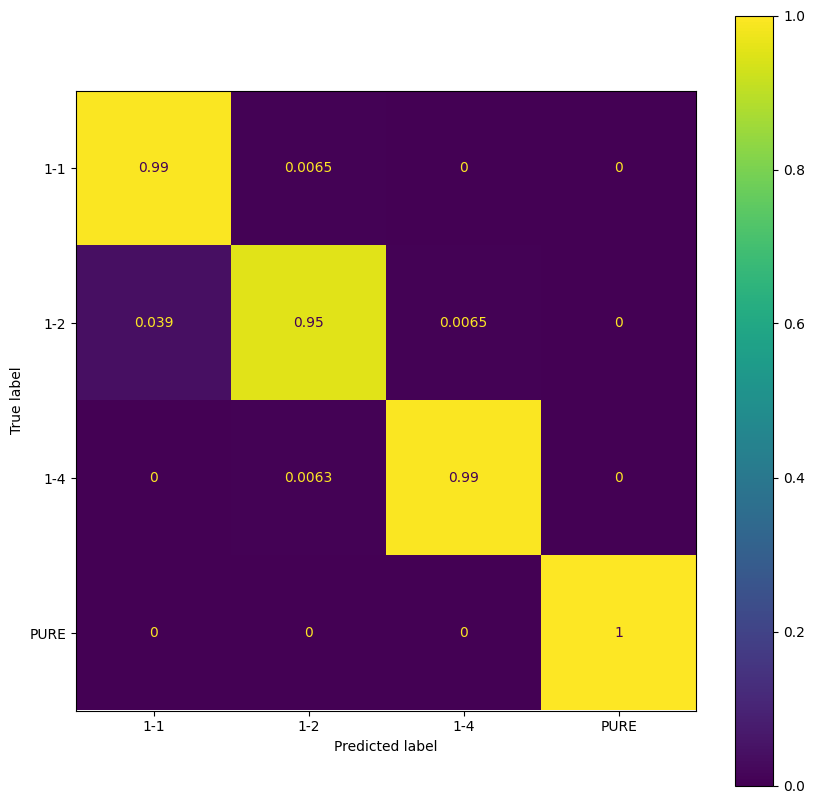

In [ ]:
confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show();
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Journal_Related/Confusion_Matrix.eps', format='eps', dpi=600)

### Demonstrating how to use the model

In [ ]:
img=image.load_img('/content/drive/MyDrive/Project_2_Conference_Journal_Work/BLACK_WHITE/1-4/CR_B_DU_1-4_012.jpg',target_size=(256,256))

In [ ]:
x=image.img_to_array(img)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [ ]:
pred=model.predict(x)

1/1 [==============================] - 0s 202ms/step


In [ ]:
print(pred)

[[2.3035313e-05 9.9997413e-01 1.0000000e+00 2.8868823e-22]]


In [ ]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

1-4
